[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/07_ulysses_compass.ipynb)

# Chapter 7 - Ulysses' Compass

## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install -q watermark

In [2]:
%load_ext watermark

In [3]:
# Core
from io import StringIO
import collections
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.formula.api as smf 

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

## Tensorflow MCMC Sampling helpers


In [6]:
USE_XLA = False              #@param
NUMBER_OF_CHAINS  = 2        #@param 
NUMBER_OF_BURNIN  = 500      #@param
NUMBER_OF_SAMPLES = 500      #@param
NUMBER_OF_LEAPFROG_STEPS = 4 #@param

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior(jdc, 
              observed_data, 
              params, 
              init_state=None, 
              bijectors=None, 
              step_size = 0.1,
              num_chains=NUMBER_OF_CHAINS,                  
              num_samples=NUMBER_OF_SAMPLES, 
              burnin=NUMBER_OF_BURNIN):
        
    if init_state is None:
        init_state = list(jdc.sample(num_chains)[:-1])

    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  

    results, sample_stats = run_hmc_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, 
                           sample_stats=sampler_stats)

    return posterior, az_trace

## Dataset URLs & Utils


In [7]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"

In [8]:
# A utility method to convert data (columns) from pandas dataframe
# into tensors with appropriate type
def df_to_tensors(name, df, columns, default_type=tf.float32):
    """ name : Name of the dataset
        df : pandas dataframe
        colums : a list of names that have the same type or
                 a dictionary where keys are the column names and values are the tensorflow type (e.g. tf.float32)
    """
    if isinstance(columns,dict):
        column_names = columns.keys()
        fields = [tf.cast(df[k].values, dtype=v) for k,v in columns.items()]    
    else:
        column_names = columns        
        fields = [tf.cast(df[k].values, dtype=default_type) for k in column_names]    
        
    # build the cls
    tuple_cls = collections.namedtuple(name, column_names)    
    # build the obj
    return tuple_cls._make(fields) 

# Introduction

## 7.1 The problem with parameters

### 7.1.1 More parameters(almost) always improve fit

##### Code 7.1


Below is a dataset for average brain volumes and body masses for 7 hominin species

In [9]:
sppnames = ["afarensis", "africanus", "habilis", "boisei",
            "rudolfensis", "ergaster", "sapiens"]
brainvolcc = np.array([438, 452, 612, 521, 752, 871, 1350])
masskg = np.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


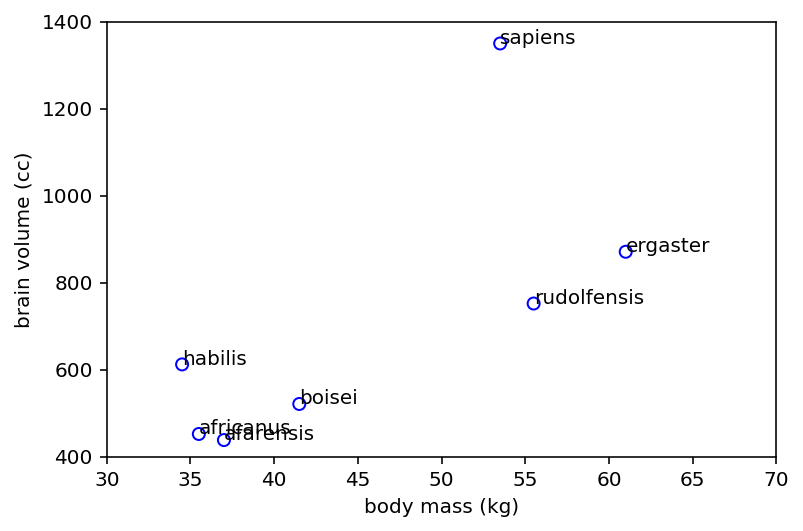

In [10]:
# Reproducing the figure in the book (there is no code fragment for this in R in the book)
plt.scatter(d.mass, d.brain, facecolors="none", edgecolors="b")
plt.gca().set(xlim=(30, 70), xlabel="body mass (kg)",
              ylim=(400,1400),
              ylabel="brain volume (cc)")

for i in range(d.shape[0]):
    plt.annotate(d.species[i], (d.mass[i], d.brain[i]))

##### Code 7.2


Author talks about linear vs polynomial regression. He is of the opinion that most of the time polynomial regression is not a good idea (at least when used blindly). But why ?

In [11]:
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()

In [12]:
tdf = df_to_tensors("Brain", d, ['mass_std', 'brain_std'])

2022-01-17 14:08:31.988476: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note - brain is not standardized as such because you can not have -ive brain

##### Code 7.3

Simplest model is the linear one and this is what we will start with

In [13]:
def model_7_1(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * mass_std
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

In [14]:
jdc_7_1 = model_7_1(tdf.mass_std)

In [15]:
init_state = [
    0.5 * tf.ones([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
    tf.zeros([NUMBER_OF_CHAINS]),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
]

jdc = jdc_7_1
observed_data = (tdf.brain_std, )

posterior_7_1, trace_7_1 = sample_posterior(
                    jdc, 
                    observed_data=observed_data,
                    params=['alpha', 'beta', 'sigma'],
                    num_samples=5000,
                    burnin=1000,
                    init_state=init_state,
                    bijectors=bijectors
                    )

In [16]:
az.summary(trace_7_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.527,0.113,0.349,0.691,0.001,0.001,5413.0,3030.0,1.0
beta,0.168,0.117,-0.008,0.347,0.001,0.001,6132.0,3527.0,1.0
sigma,-1.384,0.388,-1.940,-0.747,0.015,0.012,596.0,317.0,1.0


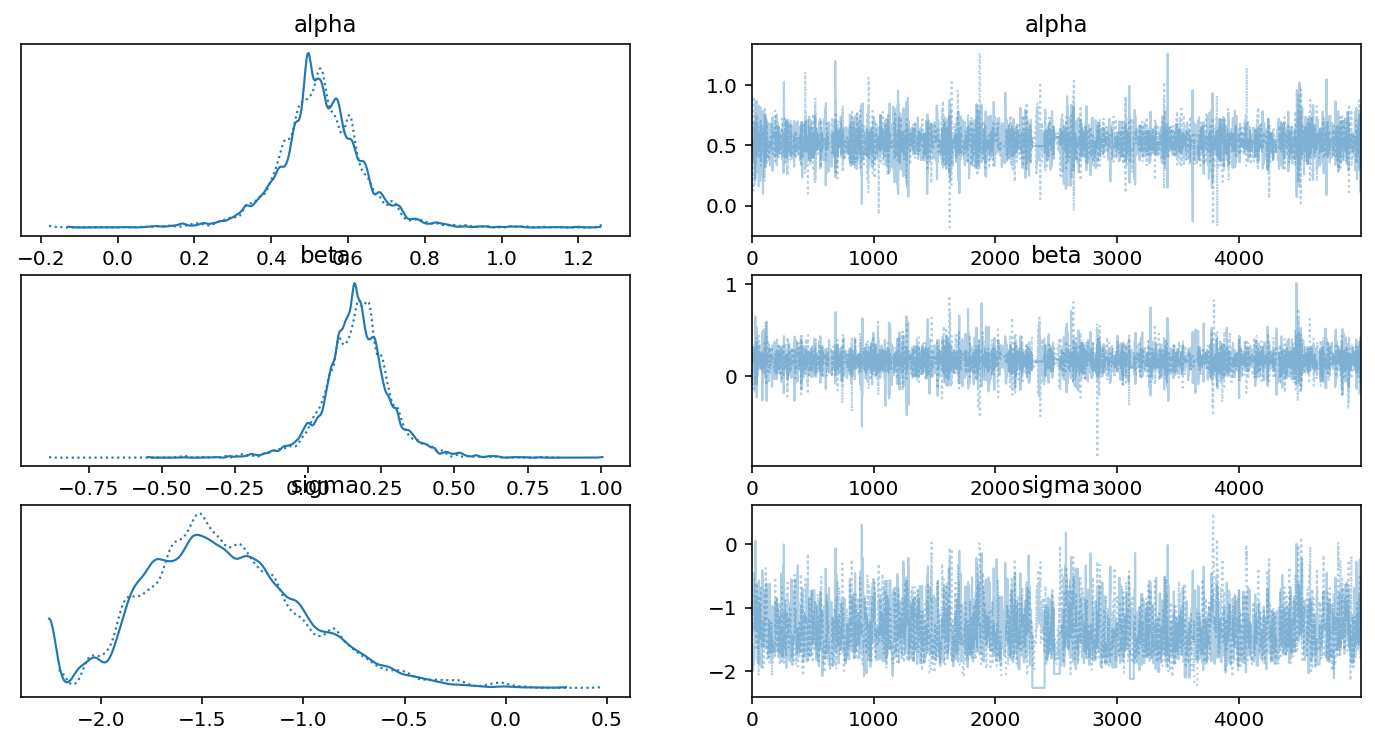

In [17]:
az.plot_trace(trace_7_1);

#### Code 7.4

OLS and Bayesian anti-essentialism. 

Use OLS for the above model. Author has used R's lm package so here we are using statsmodel (..sort of python counterpart to R's lm package) to do oridinary least square.

The OLS from the non bayesian statistics is going to provide the point estimates (which would to some extent correspond to the mean (mu) if flat priors are used). 

Note - In the text book you would see

```
m7.1_OLS <- lm( brain_std ~ mass_std , data=d ) 
post <- extract.samples( m7.1_OLS )
```

extract.samples( m7.1_OLS ) is in the source file https://github.com/rmcelreath/rethinking/blob/master/R/map-quap-class.r

Below I have replicated the code for extract.samples for (non-bayesian OLS) using statsmodel & tensorflow probabilty

In [18]:
# Use statsmodel OLS
m_7_1_OLS = smf.ols('brain_std ~ mass_std', data=d).fit()

m_7_1_OLS.params, m_7_1_OLS.cov_params()

(Intercept    0.528677
 mass_std     0.167118
 dtype: float64,
               Intercept      mass_std
 Intercept  4.980017e-03  3.981467e-19
 mass_std   3.981467e-19  5.810020e-03)

In [19]:
# Get the mean of the two parameters (intercept & coefficient for mass_std)
# and create the mu tensor
mu = tf.constant(m_7_1_OLS.params, dtype=tf.float32)
# Get the variance-covariance matrix and create the cov tensor
cov = tf.constant(m_7_1_OLS.cov_params(), dtype=tf.float32)

In [20]:
# we can build a multivariate normal distribution using the mu & cov obtained
# from the non bayesian land
mvn = tfd.MultivariateNormalTriL(
    loc=mu,
    scale_tril=tf.linalg.cholesky(cov))

posterior = mvn.sample(10000)

##### Code 7.5


Variance explained or $R^2$ is defined as:

$R^2$ = 1 - $\frac{var(residuals)}{var(outcome)}$

In [21]:
# We will have to simulate (compute) our posterior brain_std from the samples
sample_alpha = posterior_7_1["alpha"]
sample_beta  = posterior_7_1["beta"]
sample_sigma = posterior_7_1["sigma"]

ds, samples = jdc_7_1.sample_distributions(value=[
      sample_alpha,
      sample_beta, 
      sample_sigma,
      None
    ])

sample_brain_std = ds[-1].distribution.sample()

# get the mean
brain_std_mean = tf.reduce_mean(sample_brain_std, axis=1) # <--note usage of axis 1

r = brain_std_mean - d.brain_std.values

# compute the variance expained (R square)
resid_var = np.var(r, ddof=1)
outcome_var = np.var(d.brain_std.values, ddof=1)
1 - resid_var / outcome_var

0.5443309409033603

##### Code 7.6

$R^2$ is bad, the author says ! ... here is  resuable function that will used multiple times later

In [22]:
def RX_is_bad(jdc, posterior, scale=None):     
    
    sample_alpha = posterior["alpha"]
    sample_beta = posterior["beta"]
    
    if scale is None:
        sample_sigma = posterior["sigma"]
    else:
        sample_sigma = 0.001  # model number 6
        
    ds, samples = jdc.sample_distributions(value=[
      sample_alpha, 
      sample_beta, 
      sample_sigma,
      None
    ])

    sample_brain_std = ds[-1].distribution.sample()

    # get the mean
    brain_std_mean = tf.reduce_mean(sample_brain_std, axis=1) # <--note usage of axis 1

    r = brain_std_mean - d.brain_std.values

    # compute the variance expained (R square)
    resid_var = np.var(r, ddof=1)
    outcome_var = np.var(d.brain_std.values, ddof=1)
    1 - resid_var / outcome_var
        
    return 1 - resid_var / outcome_var 

##### Code 7.7

Building some more models to compare to m7.1

This one is a poymomial of second degree

In [23]:
def model_7_2(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=2))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * (mass_std ** 2)
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)  

In [24]:
# will use this method for various models
def compute_brain_body_posterior_for_simulation(beta_degree, jdc):

    if beta_degree == 1:        
        init_state = [
            0.5 * tf.ones([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS]),
        ]
    else:    
        init_state = [
            0.5 * tf.ones([NUMBER_OF_CHAINS]),
            tf.zeros([NUMBER_OF_CHAINS, beta_degree]),
            tf.zeros([NUMBER_OF_CHAINS]),
        ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
    ]
    
    observed_data = (tdf.brain_std,)

    posterior, trace= sample_posterior(
            jdc, 
            observed_data=observed_data,
            params=['alpha', 'beta', 'sigma'],
            num_samples=4000,
            burnin=1000,
            init_state=init_state,
            bijectors=bijectors)
    
    return posterior, trace

##### Code 7.8

Models of 3rd, 4th and 5th degrees

In [25]:
def model_7_3(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=3))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * (mass_std ** 2) + \
                                     beta3[...,tf.newaxis] * (mass_std ** 3)
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)
                                          
                                          
def model_7_4(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=4))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                          
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * (mass_std ** 2) + \
                                     beta3[...,tf.newaxis] * (mass_std ** 3) + \
                                     beta4[...,tf.newaxis] * (mass_std ** 4) 
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

def model_7_5(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=5))
        sigma = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="sigma") , sample_shape=1))
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                        
        beta5 = tf.squeeze(tf.gather(beta, [4], axis=-1))                                        
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * (mass_std ** 2) + \
                                     beta3[...,tf.newaxis] * (mass_std ** 3) + \
                                     beta4[...,tf.newaxis] * (mass_std ** 4) + \
                                     beta5[...,tf.newaxis] * (mass_std ** 5)
        
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=tf.exp(scale)), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

##### Code 7.9

This one is of degree 6 but the standard deviation has been replaced with constant 0.001. The author mentions that otherwise it will not work and will be explained with the help of plot later

In [26]:
def model_7_6(mass_std):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.5, scale=1.0, name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=6))        
        
        beta1 = tf.squeeze(tf.gather(beta, [0], axis=-1))
        beta2 = tf.squeeze(tf.gather(beta, [1], axis=-1))
        beta3 = tf.squeeze(tf.gather(beta, [2], axis=-1))
        beta4 = tf.squeeze(tf.gather(beta, [3], axis=-1))                                        
        beta5 = tf.squeeze(tf.gather(beta, [4], axis=-1))    
        beta6 = tf.squeeze(tf.gather(beta, [5], axis=-1))    
        
        mu = alpha[...,tf.newaxis] + beta1[...,tf.newaxis] * mass_std + \
                                     beta2[...,tf.newaxis] * (mass_std ** 2) + \
                                     beta3[...,tf.newaxis] * (mass_std ** 3) + \
                                     beta4[...,tf.newaxis] * (mass_std ** 4) + \
                                     beta5[...,tf.newaxis] * (mass_std ** 5) + \
                                     beta6[...,tf.newaxis] * (mass_std ** 6)        
        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=0.001), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

In [27]:
# for this method we need to compute the posterior differently as the model is different in terms of params
def compute_posterior_for_76_simulation(jdc_7_6):    

    init_state = [
        0.5 * tf.ones([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS, 6])
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity()
    ]
    
    observed_data = (tdf.brain_std,)

    posterior_7_6, trace_7_6 = sample_posterior(
                    jdc_7_6, 
                    observed_data=observed_data,
                    params=['alpha', 'beta'],
                    num_samples=4000,
                    burnin=1000,
                    init_state=init_state,
                    bijectors=bijectors)
    
    return posterior_7_6, trace_7_6

##### Code 7.10

In [28]:
jdc_7_1 = model_7_1(tdf.mass_std)
jdc_7_2 = model_7_2(tdf.mass_std)
jdc_7_3 = model_7_3(tdf.mass_std)
jdc_7_4 = model_7_4(tdf.mass_std)
jdc_7_5 = model_7_5(tdf.mass_std)    
jdc_7_6 = model_7_6(tdf.mass_std)    

posterior_7_1, trace_7_1 = compute_brain_body_posterior_for_simulation(1, jdc_7_1)
posterior_7_2, trace_7_2 = compute_brain_body_posterior_for_simulation(2, jdc_7_2)
posterior_7_3, trace_7_3 = compute_brain_body_posterior_for_simulation(3, jdc_7_3)
posterior_7_4, trace_7_4 = compute_brain_body_posterior_for_simulation(4, jdc_7_4)
posterior_7_5, trace_7_5 = compute_brain_body_posterior_for_simulation(5, jdc_7_5)

posterior_7_6, trace_7_6 = compute_posterior_for_76_simulation(jdc_7_6)

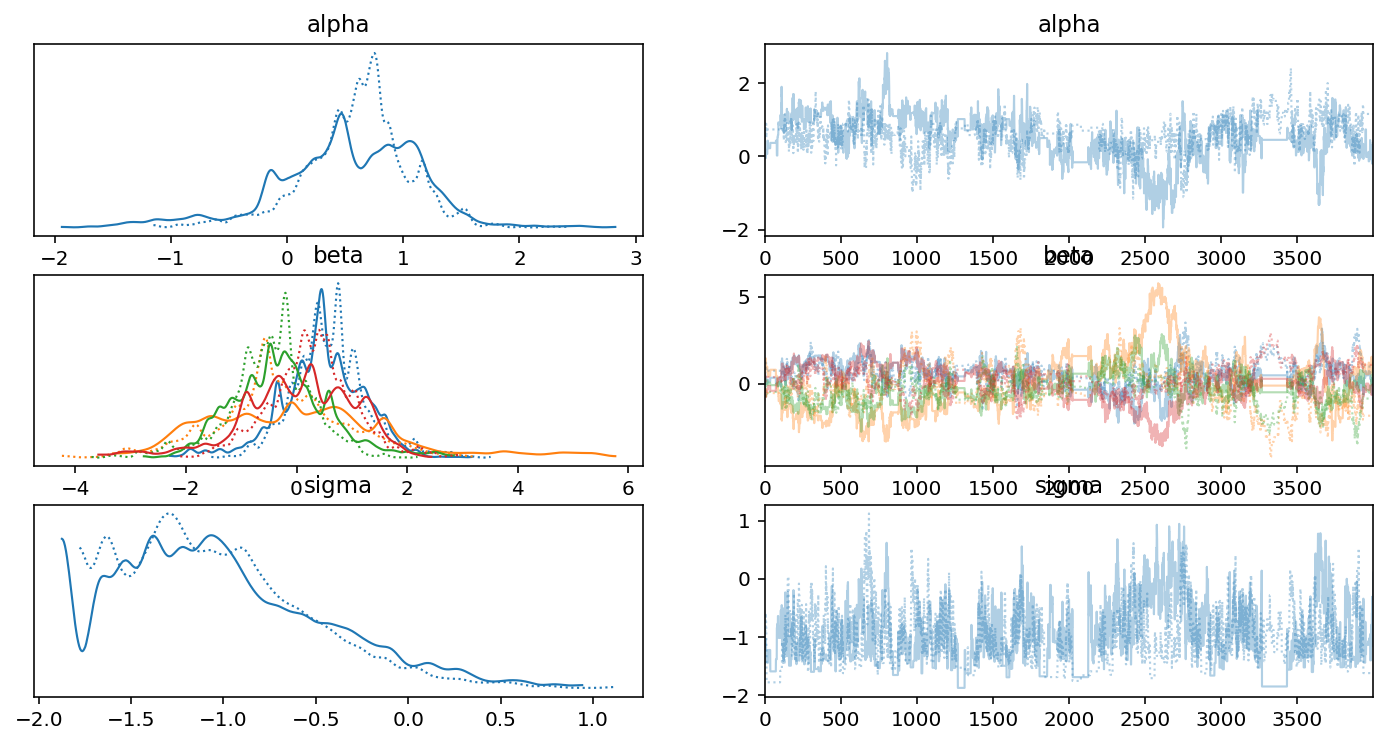

In [29]:
az.plot_trace(trace_7_4);

In [30]:
mass_seq = np.linspace(d.mass_std.min(), d.mass_std.max(), num=100)

In [31]:
def plot_model_mean(model_name, jdc, posterior, jdc_mass_seq):            
    if not "sigma" in posterior:            
        scale = 0.001  # model number 6
    else:
        scale = None
    
    plt.title("{}: R^2 = {:0.2f}".format(model_name, RX_is_bad(jdc, posterior, scale).item()))     
    
    sample_alpha = posterior["alpha"]
    sample_beta = posterior["beta"]
    
    if scale is None:
        sample_sigma = posterior["sigma"]
    else:
        sample_sigma = 0.001  # model number 6
        
    # jdc_mass_seq is the new joint distribution model
    # that uses mass_seq as the data
    #
    # Note - we are using posteriors from
    # the trace of jdc that we built earlier    
        
    ds, samples = jdc_mass_seq.sample_distributions(value=[
      sample_alpha,
      sample_beta, 
      sample_sigma,
      None
    ])

    # we get mu from the loc parameter of underlying
    # distribution which is Normal
    mu = ds[-1].distribution.loc
    
    mu_mean = tf.reduce_mean(mu, 1)
    mu_ci = tfp.stats.percentile(mu[0], (4.5, 95.5), 0)
        
    plt.scatter(d.mass_std, d.brain_std, facecolors="b", edgecolors="b")
    plt.plot(mass_seq, mu_mean[0], "k")
    
    plt.fill_between(mass_seq, mu_ci[0], mu_ci[1], color="k", alpha=0.2) 

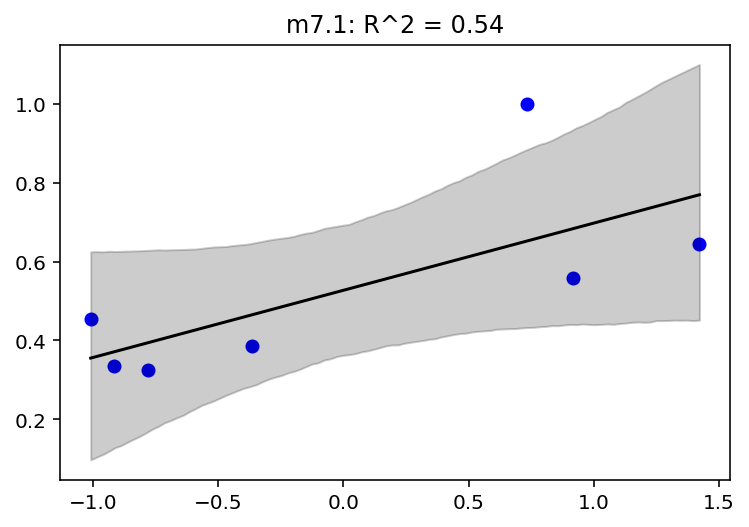

In [32]:
jdc_7_1_mass_seq = model_7_1(mass_seq)    
plot_model_mean("m7.1", jdc_7_1, posterior_7_1, jdc_7_1_mass_seq)

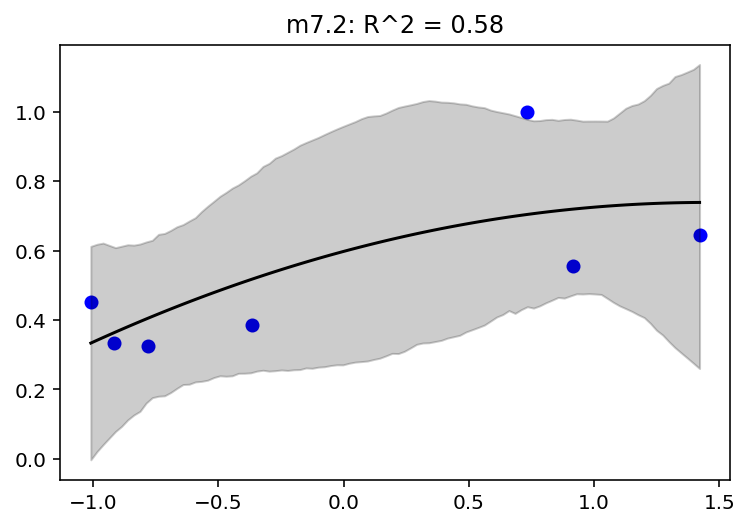

In [33]:
# Book does not provide the code snippet for other models but has corresponding figures so I am 
# doing that as well
jdc_7_2_mass_seq = model_7_2(mass_seq)
plot_model_mean("m7.2", jdc_7_2, posterior_7_2, jdc_7_2_mass_seq)

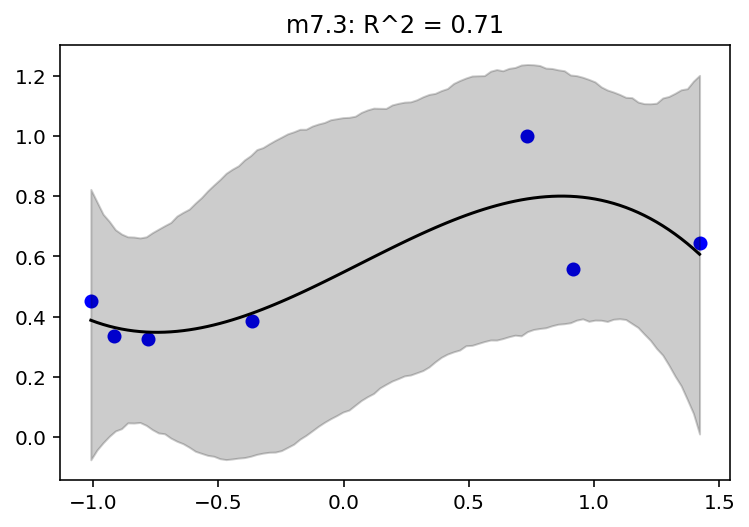

In [34]:
jdc_7_3_mass_seq = model_7_3(mass_seq)
plot_model_mean("m7.3", jdc_7_3, posterior_7_3, jdc_7_3_mass_seq)

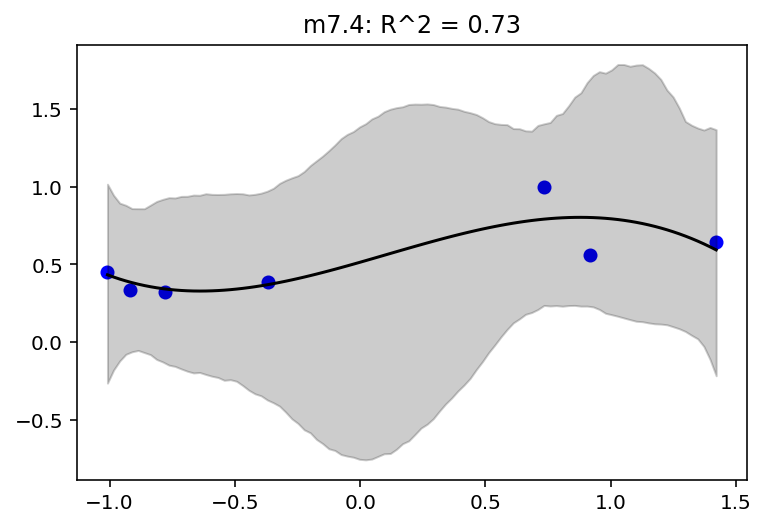

In [35]:
jdc_7_4_mass_seq = model_7_4(mass_seq)
plot_model_mean("m7.4", jdc_7_4, posterior_7_4, jdc_7_4_mass_seq)

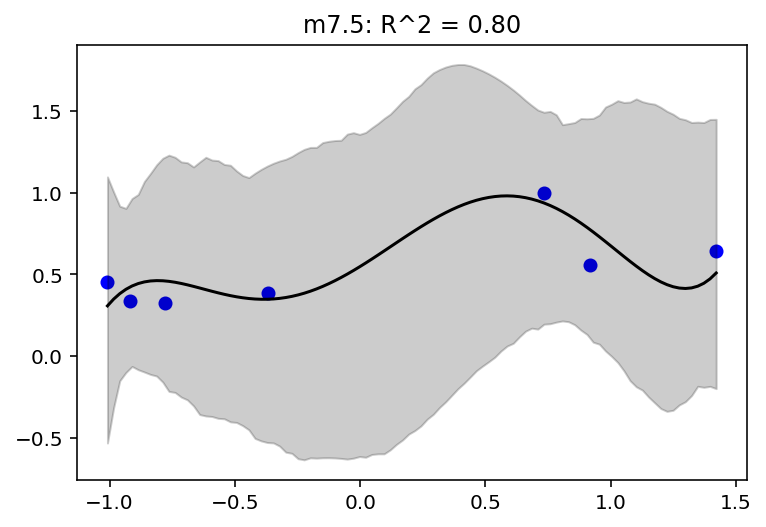

In [36]:
jdc_7_5_mass_seq = model_7_5(mass_seq)
plot_model_mean("m7.5", jdc_7_5, posterior_7_5, jdc_7_5_mass_seq)

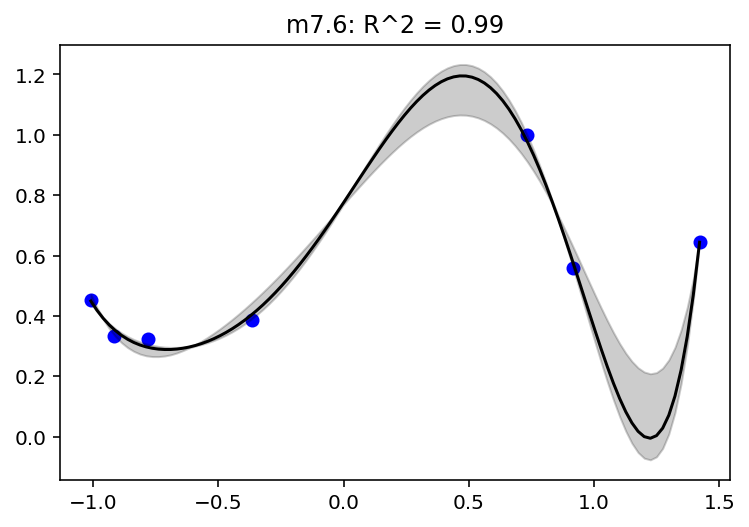

In [37]:
jdc_7_6_mass_seq = model_7_6(mass_seq)
plot_model_mean("m7.6", jdc_7_6, posterior_7_6, jdc_7_6_mass_seq)

### 7.1.2 Too few parameters hurts,too

##### Code 7.11

In [38]:
i = 1
d_minus_i = d.drop(i)

## 7.2 Entropy and accuracy

### 7.2.1 Firing the weatherperson

### 7.2.2 Information and uncertainity

##### Code 7.12

In [39]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

### 7.2.3 From entropy to accuracy

### 7.2.4 Estimating divergence

##### Code 7.13

In [40]:
def compute_log_likelihood(jdc, posterior, trace, scale=None):
    
    sample_alpha = posterior["alpha"]
    sample_beta = posterior["beta"]
    
    if scale is None:
        sample_sigma = posterior["sigma"]
    else:
        sample_sigma = 0.001  # model number 6
        
    ds, samples = jdc.sample_distributions(value=[
      sample_alpha, 
      sample_beta, 
      sample_sigma,
      None
    ])
    
    log_likelihood_total = ds[-1].distribution.log_prob(tdf.brain_std).numpy()    
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(7)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    print(log_likelihood_total.shape)
    
    return log_likelihood_total

def lppd_fn(jdc, posterior, trace, scale=None):
    ll = compute_log_likelihood(jdc, posterior, trace, scale)
    ll = tf.math.reduce_logsumexp(ll, 0) - tf.math.log(tf.cast(ll.shape[0], dtype=tf.float32))
    return np.mean(ll,0)


lppd_fn(jdc_7_1, posterior_7_1, trace_7_1)

(2, 4000, 7)


array([ 0.33119717,  0.3505246 ,  0.2684615 ,  0.35738128,  0.23298772,
        0.17051615, -0.72729564], dtype=float32)

### Overthinking

##### Code 7.14

This is simply an implementation of lppd_fn which I have done in 7.13 already

### Scoring the right data

##### Code 7.15

In [41]:
ite = ((jdc_7_1, posterior_7_1, trace_7_1), 
       (jdc_7_2, posterior_7_2, trace_7_2), 
       (jdc_7_3, posterior_7_3, trace_7_3),
       (jdc_7_4, posterior_7_4, trace_7_4),
       (jdc_7_5, posterior_7_5, trace_7_5))

In [42]:
[np.sum(lppd_fn(m[0],m[1],m[2])) for m in ite]

(2, 4000, 7)
(2, 4000, 7)
(2, 4000, 7)
(2, 4000, 7)
(2, 4000, 7)


[0.98377275, 0.74049, -0.14036165, -1.2946495, -2.9576306]

### Overthinking

##### Code 7.16 - 7.18 [TODO]

## 7.3 Golem Taming: Regularization

## 7.4 Predicting predictive accuracy

### Overthinking: WAIC calculations

##### Code 7.19

In [43]:
# There is no CSV file for cars dataset in author's repo
# hence I have inlined the data. In R this dataset much be bundled in
# and this is why his code snippets do not need the csv file

cars_data = """
"","speed","dist"
"1",4,2
"2",4,10
"3",7,4
"4",7,22
"5",8,16
"6",9,10
"7",10,18
"8",10,26
"9",10,34
"10",11,17
"11",11,28
"12",12,14
"13",12,20
"14",12,24
"15",12,28
"16",13,26
"17",13,34
"18",13,34
"19",13,46
"20",14,26
"21",14,36
"22",14,60
"23",14,80
"24",15,20
"25",15,26
"26",15,54
"27",16,32
"28",16,40
"29",17,32
"30",17,40
"31",17,50
"32",18,42
"33",18,56
"34",18,76
"35",18,84
"36",19,36
"37",19,46
"38",19,68
"39",20,32
"40",20,48
"41",20,52
"42",20,56
"43",20,64
"44",22,66
"45",23,54
"46",24,70
"47",24,92
"48",24,93
"49",24,120
"50",25,85
"""

buffer = StringIO(cars_data)
d = pd.read_csv(buffer, sep=",")

d.head()

,Unnamed: 0,speed,dist
0,1,4,2
1,2,4,10
2,3,7,4
3,4,7,22
4,5,8,16


In [44]:
# Note - 
#
# In first edition, the book used Uniform for sigma and in the second
# edition it is using Exponential; 
#
# If I use exponential the chains do not converge; the traces are seriously bad.
# In order to make it work, I have spent time trying to find an ideal number of
# samples & burin. The configuration that has the most impact is the initialization
# state. For the sigma if I use the init state of 60 then the chains converge sometimes ..
# I have observed that even after this setting the convergence is not systematic. After running
# it few times I see that it has R_hat of 2 and that skews the results
# 
# Edition 1 model (i.e. using Uniform for scale) is very stable
#
#
# I have ran the model in R (using rehinking & rstan) as well and there I am able to 
# work with the model definition as it is in Edition 2

USE_EDITION_2_SPEC = True

def cars_model(speed):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=100., name="alpha") , sample_shape=1))
        beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=10.0, name="beta") , sample_shape=1))
        
        if USE_EDITION_2_SPEC:
            sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma") , sample_shape=1))
        else:
            sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=30., name="sigma") , sample_shape=1))        
        
        mu = alpha[...,tf.newaxis] + beta[...,tf.newaxis] * speed
        scale = sigma[...,tf.newaxis]        
        
        brain_std = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

In [45]:
jdc_cars = cars_model(tf.cast(d.speed.values, dtype=tf.float32))

if USE_EDITION_2_SPEC:

    init_state = [
        tf.ones([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
        60. * tf.ones([NUMBER_OF_CHAINS]),  # <--- this makes it work (somewhat, not systematic !)
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp(),
    ]
else:
    
    init_state = [
        tf.ones([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
    ]
    
    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
    ]

observed_data = (tf.cast(d.dist.values, dtype=tf.float32),)

# here I am increasing the sampling size
# to see if that helps
posterior_cars, trace_cars = sample_posterior(
                                jdc_cars, 
                                observed_data=observed_data,
                                params=['alpha', 'beta', 'sigma'],
                                num_samples=5000,
                                burnin=2000,
                                init_state=init_state,
                                bijectors=bijectors)

In [46]:
az.summary(trace_cars, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-3.173,1.313,-5.036,-1.170,0.814,0.681,3.0,26.0,1.93
beta,3.091,0.139,2.880,3.313,0.044,0.032,11.0,220.0,1.16
sigma,14.351,1.188,12.494,16.231,0.093,0.067,174.0,172.0,1.01


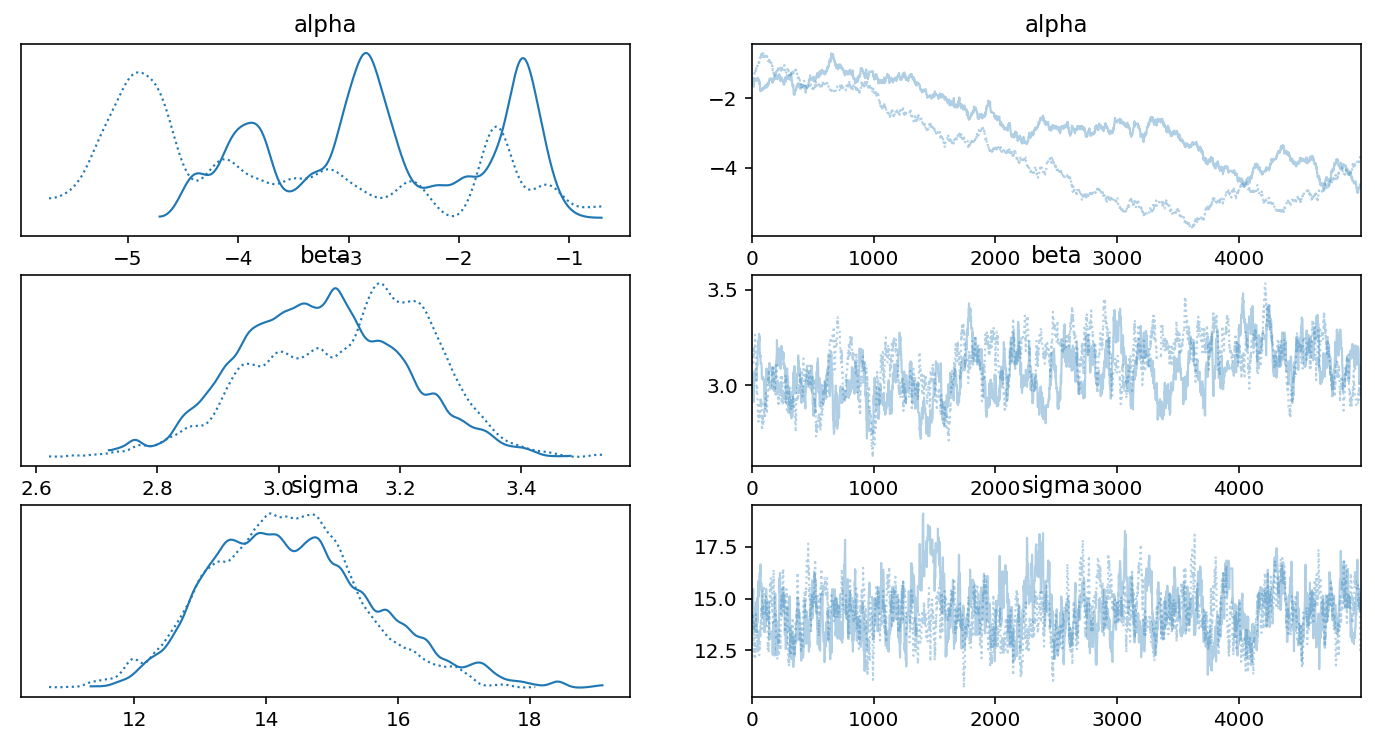

In [47]:
az.plot_trace(trace_cars);

##### Code 7.20

In [48]:
n_samples = 2000

def logprob_fn(s):
    mu = posterior_cars["alpha"][0][s] + posterior_cars["beta"][0][s] * d.speed.values
    sigma = posterior_cars["sigma"][0][s]
    scale = sigma   
    
    return tfd.Normal(
        loc=tf.cast(mu, dtype=tf.float32), 
        scale=tf.cast(scale, dtype=tf.float32)).log_prob(d.dist.values)

logprob = np.array(list(map(logprob_fn, np.arange(n_samples)))).T

logprob.shape

(50, 2000)

##### Code 7.21

In [49]:
n_cases = d.shape[0]
lppd = tf.math.reduce_logsumexp(logprob, 1) - tf.math.log(tf.cast(n_samples, dtype=tf.float32))

##### Code 7.22

In [50]:
pWAIC = np.var(logprob, 1)

##### Code 7.23

In [51]:
-2 * (np.sum(lppd) - np.sum(pWAIC))

424.2729187011719

##### Code 7.24

In [52]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

15.82108634657336

### 7.4.3 Comparing CV, PSIS, and WAIC

## 7.5 Model comparison

##### Code 7.25


Here we need to first redefine models from the previous chapters i.e. m6_6,m6_7,m6_8 and compute the log likelihoods as well and only then we will compute the WAIC

In [53]:
_SEED = 71

# Note - even after providing SeedStream and generated seeds
# it still does not respect it
def simulate():
    seed = tfp.util.SeedStream(_SEED, salt="sim_heights")

    # number of plants
    N = 100

    # simulate initial heights
    h0 = tfd.Normal(loc=10., scale=2.).sample(N, seed=seed())

    # assign treatments and simulate fungus and growth
    treatment = tf.repeat([0., 1.], repeats=N // 2)
    
    fungus = tfd.Binomial(total_count=1., probs=(0.5 - treatment * 0.4)).sample(seed=seed())
    
    h1 = h0 + tfd.Normal(loc=5. - 3. * fungus, scale=1.).sample(seed=seed())

    # compose a clean data frame
    d = {"h0":h0, "h1":h1, "treatment":treatment, "fungus":fungus}
    
    return d
    
d_dict = simulate()

az.summary(d_dict, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,9.894,2.143,6.421,12.93
h1,13.609,2.696,8.782,17.34
treatment,0.500,0.503,0.000,1.00
fungus,0.350,0.479,0.000,1.00


In [54]:
d = pd.DataFrame.from_dict(d_dict)
tdf = df_to_tensors('SimulatedTreatment', d, ['h0', 'h1', 'treatment', 'fungus'])

In [55]:
def model_6_6(h0):
    def _generator():
      p = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.25, name="p"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = tf.squeeze(h0[tf.newaxis,...] * p[...,tf.newaxis])
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_6 = model_6_6(tdf.h0)

NUM_CHAINS_FOR_6_6 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_6]),
    tf.ones([NUM_CHAINS_FOR_6_6])    
]

bijectors = [
    tfb.Exp(),
    tfb.Exp()
]

posterior_6_6, trace_6_6 = sample_posterior(
                                jdc_6_6, 
                                observed_data=(tdf.h1,), 
                                num_chains=NUM_CHAINS_FOR_6_6,
                                init_state=init_state,
                                bijectors=bijectors,
                                num_samples=2000, 
                                burnin=1000,
                                params=['p', 'sigma'])

az.summary(trace_6_6, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.357,0.019,1.328,1.387,0.000,0.000,1613.0,1527.0,1.0
sigma,1.906,0.135,1.696,2.126,0.004,0.003,1268.0,1714.0,1.0


In [56]:
def model_6_7(h0, treatment, fungus):
    def _generator():
      a = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.2, name="a"), sample_shape=1))      
      bt = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bt"), sample_shape=1))    
      bf = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bf"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      p = a[...,tf.newaxis] + bt[...,tf.newaxis] * treatment + bf[...,tf.newaxis] * fungus
        
      mu = h0 * p
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_7 = model_6_7(tdf.h0, tdf.treatment, tdf.fungus)

NUM_CHAINS_FOR_6_7 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_7]),
    tf.zeros([NUM_CHAINS_FOR_6_7]),
    tf.zeros([NUM_CHAINS_FOR_6_7]),
    tf.ones([NUM_CHAINS_FOR_6_7])    
]

bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

posterior_6_7, trace_6_7 = sample_posterior(
                    jdc_6_7, 
                    observed_data=(tdf.h1,), 
                    num_chains=NUM_CHAINS_FOR_6_7,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bt', 'bf', 'sigma'])

az.summary(trace_6_7, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.456,0.028,1.409,1.500,0.001,0.001,996.0,1804.0,1.0
bt,-0.013,0.033,-0.061,0.045,0.001,0.001,1329.0,1676.0,1.0
bf,-0.278,0.035,-0.332,-0.222,0.001,0.001,1187.0,1422.0,1.0
sigma,1.399,0.104,1.217,1.543,0.005,0.004,394.0,680.0,1.0


In [57]:
def model_6_8(h0, treatment):
    def _generator():
      a = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=0.2, name="a"), sample_shape=1))      
      bt = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="bt"), sample_shape=1))    
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      p = a[...,tf.newaxis] + bt[...,tf.newaxis] * treatment 
        
      mu = h0 * p
      scale = sigma[..., tf.newaxis]  
        
      h1 = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale, name="h1"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_6_8 = model_6_8(tdf.h0, tdf.treatment)

NUM_CHAINS_FOR_6_8 = 2

init_state = [
    tf.ones([NUM_CHAINS_FOR_6_8]),
    tf.zeros([NUM_CHAINS_FOR_6_8]),
    tf.ones([NUM_CHAINS_FOR_6_8])    
]

bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Exp()
]

posterior_6_8, trace_6_8 = sample_posterior(
                    jdc_6_8, 
                    observed_data=(tdf.h1,), 
                    num_chains=NUM_CHAINS_FOR_6_8,
                    init_state=init_state,
                    bijectors=bijectors,
                    num_samples=2000, 
                    burnin=1000,
                    params=['a', 'bt', 'sigma'])

az.summary(trace_6_8, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.288,0.026,1.248,1.329,0.000,0.000,2650.0,1579.0,1.0
bt,0.132,0.037,0.071,0.186,0.001,0.000,3101.0,1029.0,1.0
sigma,1.781,0.132,1.576,1.985,0.004,0.003,890.0,969.0,1.0


In [58]:
# compute the log likelihoods
def compute_log_likelihood_6_7(jdc, posterior, trace): 
    
    sample_a  = posterior["a"]
    sample_bt = posterior["bt"]
    sample_bf = posterior["bf"]
    sample_sigma = posterior["sigma"]

    ds, samples = jdc.sample_distributions(value=[
      sample_a, 
      sample_bt,
      sample_bf,
      sample_sigma, 
      None
    ])

    log_likelihood_total = ds[-1].distribution.log_prob(tdf.h1).numpy()    
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(100)]
    
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

ll_6_7 = compute_log_likelihood_6_7(jdc_6_7, posterior_6_7, trace_6_7)

In [59]:
# WAIC for model_6_7
WAIC_m6_7 = az.waic(trace_6_7, pointwise=True, scale="deviance")
WAIC_m6_7

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   353.63    15.04
p_waic            3.63        -

There has been a warning during the calculation. Please check the results.

##### Code 7.26

In [60]:
# likelihoods for rest of the 6_X models
def compute_log_likelihood_6_6(jdc, posterior, trace):    
    
    sample_p  = posterior["p"]
    sample_sigma = posterior["sigma"]
    
    ds, samples = jdc.sample_distributions(value=[
      sample_p, 
      sample_sigma, 
      None
    ])

    log_likelihood_total = ds[-1].distribution.log_prob(tdf.h1).numpy()    
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(100)]
    
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

ll_6_6 = compute_log_likelihood_6_6(jdc_6_6, posterior_6_6, trace_6_6)

In [61]:
def compute_log_likelihood_6_8(jdc, posterior, trace):    
    
    sample_a  = posterior["a"]
    sample_bt = posterior["bt"]
    sample_sigma = posterior["sigma"]

    ds, samples = jdc.sample_distributions(value=[
      sample_a, 
      sample_bt, 
      sample_sigma, 
      None
    ])

    log_likelihood_total = ds[-1].distribution.log_prob(tdf.h1).numpy()    
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(100)]
    
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

ll_6_8 = compute_log_likelihood_6_8(jdc_6_8, posterior_6_8, trace_6_8)

In [62]:
compare_df = az.compare({"m6.6": trace_6_6, "m6.7": trace_6_7, "m6.8": trace_6_8}, ic='waic', scale="deviance")

compare_df

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6.7,0,353.626053,3.627182,0.000000,0.983976,15.036280,0.000000,True,deviance
m6.8,1,403.526378,2.770123,49.900325,0.000000,12.302754,11.405116,False,deviance
m6.6,2,414.248073,1.591894,60.622020,0.016024,11.501484,13.072877,False,deviance


##### Code 7.27 

In [63]:
WAIC_m6_7 = az.waic(trace_6_7, pointwise=True, scale="deviance")
WAIC_m6_8 = az.waic(trace_6_8, pointwise=True, scale="deviance")

# pointwise values are stored in the waic_i attribute.
diff_m_6_7_m_6_8 = WAIC_m6_7.waic_i - WAIC_m6_8.waic_i

n = len(diff_m_6_7_m_6_8)

np.sqrt(n * np.var(diff_m_6_7_m_6_8)).values

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


array(11.40511611)

##### Code 7.28

In [64]:
40.0 + np.array([-1, 1]) * 10.4 * 2.6

array([12.96, 67.04])

##### Code 7.29

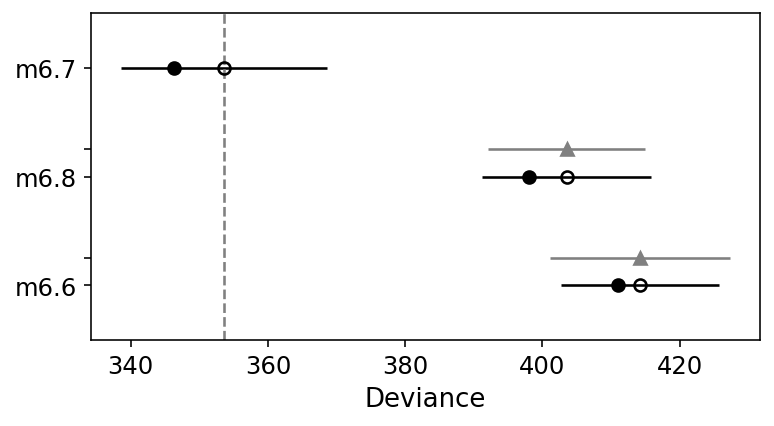

In [65]:
az.plot_compare(compare_df);

##### Code 7.30

In [66]:
WAIC_m6_6 = az.waic(trace_6_6, pointwise=True, scale="deviance")

diff_m6_6_m6_8 = WAIC_m6_6.waic_i - WAIC_m6_8.waic_i

n = WAIC_m6_6.n_data_points

np.sqrt(n * np.var(diff_m6_6_m6_8)).values

array(7.23758868)

##### Code 7.31

In [67]:
dSE = lambda waic1, waic2: np.sqrt(
    n * np.var(waic1.waic_i.values - waic2.waic_i.values))
data = {"m6.6": WAIC_m6_6, "m6.7": WAIC_m6_7, "m6.8": WAIC_m6_8}
pd.DataFrame(
    {row: {col: dSE(row_val, col_val) for col, col_val in data.items()}
     for row, row_val in data.items()})

,m6.6,m6.7,m6.8
m6.6,0.000000,13.072877,7.237589
m6.7,13.072877,0.000000,11.405116
m6.8,7.237589,11.405116,0.000000


### 7.5.2 Outliers and other illusions

##### Code 7.32

In [68]:
d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [69]:
tdf = df_to_tensors('Waffle', d, ['A', 'D', 'M'])

In [70]:
def model_5_1(A):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaA = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaA"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.Normal(loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

def model_5_2(M):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaM = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaM"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaM[...,tf.newaxis] * M
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.Normal(loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)
        
    
def model_5_3(A, M):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaA = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaA"), sample_shape=1))
        betaM = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaM"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A +  betaM[...,tf.newaxis] * M
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.Normal(loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_5_1 = model_5_1(tdf.A)
jdc_5_2 = model_5_2(tdf.M)
jdc_5_3 = model_5_3(tdf.A, tdf.M)


def compute_posterior_5_1_and_2(jdc):
    init_state = [
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp(),
    ]

    observed_data = (tdf.D,)

    # here I am increasing the sampling size
    # to see if that helps
    posterior, trace = sample_posterior(
                        jdc, 
                        observed_data=observed_data,
                        params=['alpha', 'beta', 'sigma'],
                        num_samples=1000,
                        burnin=500,
                        init_state=init_state,
                        bijectors=bijectors)
    
    return posterior, trace

def compute_posterior_5_3():
    init_state = [
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp(),
    ]

    observed_data = (tdf.D,)

    # here I am increasing the sampling size
    # to see if that helps
    posterior, trace = sample_posterior(
                        jdc_5_3, 
                        observed_data=observed_data,
                        params=['alpha', 'betaA', 'betaM', 'sigma'],
                        num_samples=1000,
                        burnin=500,
                        init_state=init_state,
                        bijectors=bijectors)
    
    return posterior, trace
        
    
posterior_5_1, trace_5_1 = compute_posterior_5_1_and_2(jdc_5_1)
posterior_5_2, trace_5_2 = compute_posterior_5_1_and_2(jdc_5_2)
posterior_5_3, trace_5_3 = compute_posterior_5_3()

##### Code 7.33

In [71]:
def compute_log_likelihood_m5_1_2(jdc, posterior, trace):
    sample_alpha = posterior["alpha"]
    sample_beta  = posterior["beta"]
    sample_sigma = posterior["sigma"]

    ds, samples = jdc.sample_distributions(value=[
      sample_alpha,
      sample_beta,
      sample_sigma,
      None
    ])

    log_likelihood_total = ds[-1].distribution.log_prob(tdf.D).numpy()    
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(50)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

def compute_log_likelihood_m5_3(jdc, posterior, trace):
    sample_alpha = posterior["alpha"]
    sample_betaA = posterior["betaA"]
    sample_betaM = posterior["betaM"]
    sample_sigma = posterior["sigma"]

    ds, samples = jdc.sample_distributions(value=[
      sample_alpha,
      sample_betaA,
      sample_betaM,
      sample_sigma,
      None
    ])

    log_likelihood_total = ds[-1].distribution.log_prob(tdf.D).numpy()    
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(50)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

    

In [72]:
ll_5_1 = compute_log_likelihood_m5_1_2(jdc_5_1, posterior_5_1, trace_5_1)
ll_5_2 = compute_log_likelihood_m5_1_2(jdc_5_2, posterior_5_2, trace_5_2)
ll_5_3 = compute_log_likelihood_m5_3(jdc_5_3, posterior_5_3, trace_5_3)

In [73]:
az.compare({"m5.1": trace_5_1, "m5.2": trace_5_2, 'm5.3' : trace_5_3}, scale="deviance")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5.1,0,125.913810,3.817603,0.000000,0.894326,13.009040,0.000000,False,deviance
m5.3,1,128.149216,5.046081,2.235406,0.000000,12.813288,0.841097,False,deviance
m5.2,2,139.433073,3.013939,13.519263,0.105674,9.804009,9.418281,False,deviance


##### Code 7.34

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


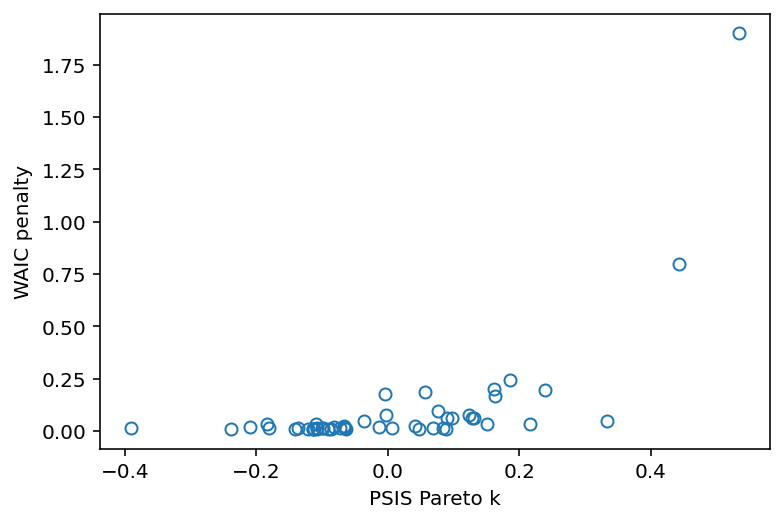

In [74]:
PSIS_m5_3 = az.loo(trace_5_3, pointwise=True, scale="deviance")
WAIC_m5_3 = az.waic(trace_5_3, pointwise=True, scale="deviance")

penalty = trace_5_3.sample_stats.log_likelihood.stack(
    sample=("chain", "draw")).var(dim="sample").values
plt.plot(PSIS_m5_3.pareto_k.values, penalty, "o", mfc="none")
plt.gca().set(xlabel="PSIS Pareto k", ylabel="WAIC penalty");

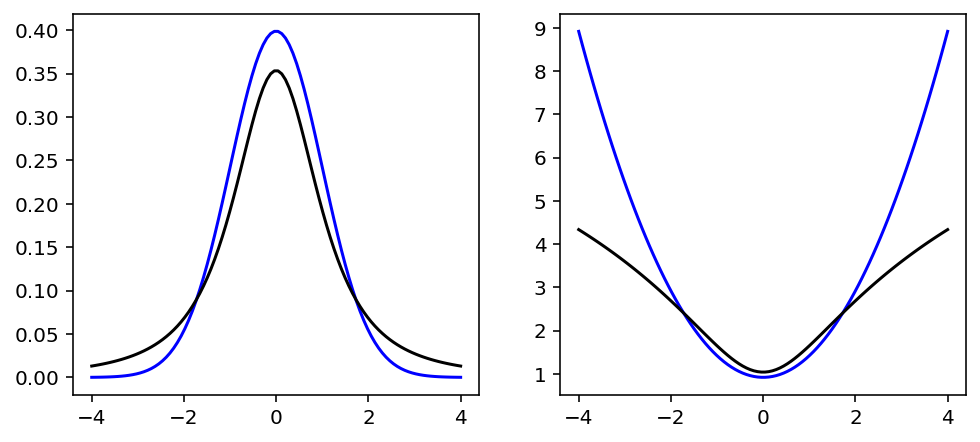

In [75]:
# reproduce figure 7.11

v = tf.cast(tf.linspace(-4, 4, 100), dtype=tf.float32)

g = tfd.Normal(loc=0., scale=1.)
t = tfd.StudentT(df=2, loc=0., scale=1.)

fig, (ax, lax) = plt.subplots(1, 2, figsize=[8, 3.5])

ax.plot(v, g.prob(v), color="b")
ax.plot(v, t.prob(v), color="k")

lax.plot(v, -g.log_prob(v), color="b")
lax.plot(v, -t.log_prob(v), color="k");

##### Code 7.35

In [76]:
def model_5_3t(A, M):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.2, name="alpha"), sample_shape=1))
        betaA = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaA"), sample_shape=1))
        betaM = yield Root(tfd.Sample(tfd.Normal(loc=0.,scale=0.5, name="betaM"), sample_shape=1))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
        mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A +  betaM[...,tf.newaxis] * M
        scale = sigma[...,tf.newaxis]
        
        D = yield tfd.Independent(tfd.StudentT(df=2., loc=mu,scale=scale), reinterpreted_batch_ndims=1)
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_5_3t = model_5_3t(tdf.A, tdf.M)

def compute_posterior_5_3t():
    init_state = [
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.zeros([NUMBER_OF_CHAINS]),
        tf.ones([NUMBER_OF_CHAINS]),
    ]

    bijectors = [
        tfb.Identity(),
        tfb.Identity(),
        tfb.Identity(),
        tfb.Exp(),
    ]

    observed_data = (tdf.D,)

    # here I am increasing the sampling size
    # to see if that helps
    posterior, trace = sample_posterior(
                        jdc_5_3t, 
                        observed_data=observed_data,
                        params=['alpha', 'betaA', 'betaM', 'sigma'],
                        num_samples=1000,
                        burnin=500,
                        init_state=init_state,
                        bijectors=bijectors)
    
    return posterior, trace

posterior_5_3t, trace_5_3t = compute_posterior_5_3t()

def compute_log_likelihood_m5_3t(jdc, posterior, trace):
    sample_alpha = posterior["alpha"]
    sample_betaA = posterior["betaA"]
    sample_betaM = posterior["betaM"]
    sample_sigma = posterior["sigma"]

    ds, samples = jdc.sample_distributions(value=[
      sample_alpha,
      sample_betaA,
      sample_betaM,
      sample_sigma,
      None
    ])

    log_likelihood_total = ds[-1].distribution.log_prob(tdf.D).numpy()    
    
    # we are inserting the log likelihood in the trace
    # as well though not required for this exercise
    sample_stats = trace.sample_stats    
    coords = [sample_stats.coords['chain'], sample_stats.coords['draw'], np.arange(50)]
    sample_stats["log_likelihood"] = xr.DataArray(
        log_likelihood_total, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
    return log_likelihood_total

In [77]:
ll = compute_log_likelihood_m5_3t(jdc_5_3t, posterior_5_3t, trace_5_3t)

In [78]:
az.loo(trace_5_3, pointwise=True, scale="deviance")

Computed from 2000 by 50 log-likelihood matrix

             Estimate       SE
deviance_loo   128.15    12.81
p_loo            5.05        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   98.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [79]:
az.compare({'m5.3' : trace_5_3, 'm5.3t' : trace_5_3t}, scale="deviance")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5.3,0,128.149216,5.046081,0.000000,0.821909,12.813288,0.000000,False,deviance
m5.3t,1,133.062678,6.219059,4.913463,0.178091,11.417742,5.872904,False,deviance


In [80]:
az.summary(trace_5_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.004,0.100,-0.152,0.154,0.005,0.003,411.0,836.0,1.00
betaA,-0.603,0.164,-0.906,-0.383,0.008,0.006,430.0,198.0,1.00
betaM,-0.066,0.166,-0.318,0.188,0.008,0.009,431.0,229.0,1.01
sigma,0.826,0.089,0.684,0.959,0.003,0.002,648.0,430.0,1.00


In [81]:
az.summary(trace_5_3t, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.026,0.107,-0.133,0.208,0.013,0.009,65.0,217.0,1.03
betaA,-0.693,0.141,-0.939,-0.491,0.005,0.004,885.0,343.0,1.00
betaM,0.044,0.203,-0.281,0.337,0.006,0.009,999.0,250.0,1.01
sigma,0.577,0.093,0.408,0.695,0.002,0.002,1854.0,203.0,1.01
